## Note:
Because of some trouble in installing the numba package on my mac, I had to use Google Colab as a different tool to edit and run my code. Consequently this is the output I got. I tried to do my best on those exercises but did not manage to complete them all due to some difficulty in learning the things and solving problems on my own. I report the ones I believe have been solved properly.

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [5]:
import numpy as np
from numba import vectorize, int64, float32

@vectorize([float32(int64)], target='parallel', fastmath=True) 
def vec_log(x):
    c =  np.log(x)
    return c

@vectorize([float32(int64)], target='parallel', fastmath=True) 
def vec_exp(x):
    c =  np.exp(x)
    return c

A = [2, 5, 10, 3, 8]



print(vec_log(A))
print(vec_exp(A))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

<ipython-input-24-7a8bf8ceb6a8>:9: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "gauss" failed type inference due to: Untyped global name 'G': cannot determine Numba type of <class 'scipy.stats._distn_infrastructure.rv_frozen'>

File "<ipython-input-24-7a8bf8ceb6a8>", line 11:
def gauss(x):
  y = G.pdf(x)
  ^

  @jit
/usr/local/lib/python3.6/dist-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "gauss" was compiled in object mode without forceobj=True.

File "<ipython-input-24-7a8bf8ceb6a8>", line 10:
@jit
def gauss(x):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/numba/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-us

The pdf value in 0 is: 0.2476


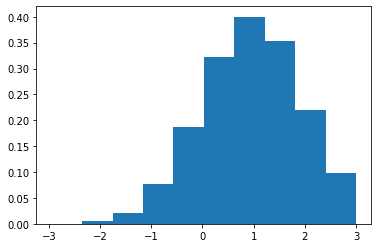

In [24]:
import scipy.stats as stats
import matplotlib.pyplot as plt
from numba import jit, njit, vectorize, cuda

lower, upper = -3, 3
mu, sigma = 1., 1.
G = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

@jit
def gauss(x):
  y = G.pdf(x)
  X = G.rvs(size = 10**5)
  print('The pdf value in 0 is: %.4f' % y)
  plt.hist(X, density=True)
  plt.show()


gauss(0)

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

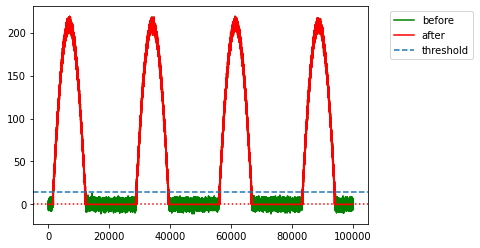

In [62]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

th = 15


@jit("void(int16[:])")
def zero_supp(data):
  for i in range(len(data)):
    if data[i] < 15: data[i] = 0


p1, = plt.plot(data, 'g-', label= 'before')  
zero_supp(data)
p2, =  plt.plot(data, 'r-', label='after')
th = plt.axhline(15,label= 'threshold', ls = '--')
plt.axhline(0, color = 'red', ls = ':')
plt.legend(handles=[p1, p2, th],bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


    

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [26]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

@jit
def k(x,y, a = 1., c= 0.):
  z = np.tanh(a*np.dot(x.T,y)+c)
  return z

print(k(X,Y))


[[0.55310362 0.73757694 0.41873539]
 [0.50506761 0.70767981 0.3997723 ]
 [0.70742666 0.70648475 0.39900457]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [ ]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = 
B = 

# Configure the blocks
threadsperblock = 
blockspergrid_x = 
blockspergrid_y = 
blockspergrid = 

